In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Alphabet import generic_protein
import re

In [2]:
# read in neut data

neut_file_path = '../data/2G12_IC50_IC80.txt'

neuts = pd.read_table(neut_file_path, header=0)
neuts.rename(columns={'Virus name':'name', 
              'Subtype':'subtype',
              '2G12: IC50 geometric mean':'IC50',
              '2G12: IC80 geometric mean':'IC80'}, inplace=True)
# neuts.set_index('name', inplace=True)
neuts.drop(['Tier', 'Country', 'Accession', 'Alias', 'Seq data', 
            ' 2G12: IC50 by study', ' 2G12: IC80 by study', 'Unnamed: 11'], 
            axis=1, inplace=True)
neuts = neuts[neuts.name != 'Geometric mean of detected']
neuts = neuts[neuts.name != 'Geometric mean of all(undetected set to 100)'] 
neuts = neuts[neuts.name != '% detected (detected/total)'] 

In [3]:
# read in sequence data

virus_name = []
virus_seq = []
passed_seqs = []

fasta_file_path = '../data/2G12 virus aa align.fasta'

for seq_record in SeqIO.parse(fasta_file_path, 'fasta', 
                              alphabet=generic_protein):
    try:
        virus_name.append(seq_record.id.split('.')[2])
        virus_seq.append(seq_record.seq)
    except:
        passed_seqs.append(seq_record)

HXB2 = passed_seqs[0]

In [4]:
# convert sequence data to DataFrame

seq_dict = {'sequence' : pd.Series(virus_seq, index=virus_name, 
                                   dtype='object')}
seq_df = pd.DataFrame(seq_dict)

In [5]:
# merge neuts and seq_df

neutdf = pd.merge(neuts, seq_df, how='inner', left_on='name', 
                    right_index=True)

In [6]:
# define neut categories

def binarize_IC50(row):
    if '>' in row.IC50:
        return 0
    else:
        value = float(row.IC50)
        return 0 if value > 50 else 1

neutdf['is_neutralized'] = neutdf.apply(binarize_IC50, axis=1)


In [7]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized
0,0013095_2_11,C,UD:>50,UD:>50,"(M, R, V, K, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0
1,001428_2_42,C,UD:>50,UD:>50,"(M, R, V, R, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0
2,0041_V3_C18,C,UD:>50,-,"(M, R, V, R, G, I, L, R, N, W, -, Q, L, W, W, ...",0
3,0077_V1_C16,C,UD:>50,UD:>50,"(M, R, V, M, G, S, M, R, N, C, -, Q, R, W, W, ...",0
4,00836_2_5,C,UD:>50,UD:>50,"(M, R, V, R, G, I, R, R, N, Y, -, Q, H, W, W, ...",0


# Feature Extraction

    Tokenize sequences w/ position value and amino acid identity
    Tokenize PNGS sites with a regex
    Vectorize tokens and create dataframe of dummy variables
    

In [8]:
# define function to tokenize sequence
# input = sequence object, output = dictionary where index is position and
# token is amino acid identity at that position

amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def sequence_tokenizer(seq):
    """
    
    """
    seq_list = list(str(seq).strip('*'))
    working_peptide = list(enumerate(seq_list, start=1))
    peptide_dict = {}
    for index, amino in working_peptide:
        if amino in amino_acids:
            peptide_dict.update({index : amino})
        else: 
            pass
    return peptide_dict


In [9]:
# define function to tokenize potential N-linked glycosylation sites 
# (PNGS) in sequence
# input = sequence object, output = dictionary where index is position
# and token = 'PNGS'

def PNGS_tokenizer(seq):
    seq_string = str(seq).strip('*')
    PNGS_dict = {m.start(0)+1 : 'PNGS' 
                for m in re.finditer(r"N[^P][ST]", seq_string)}
    return PNGS_dict


In [10]:
# define feature extraction function where input = seq object and 
# output = one dictionary of all features

def get_features(seq, use_positions=True, use_PNGS=True):
    features = {}
    if use_positions:
        sequence_features = sequence_tokenizer(seq)
        features.update(sequence_features)
    if use_PNGS:
        PNGS_features = PNGS_tokenizer(seq)
        features.update(PNGS_features)
    return features


In [11]:
# map get_features function to sequence column of neutdf

neutdf['features_dict'] = neutdf.sequence.map(get_features)


In [12]:
neutdf.head()

,name,subtype,IC50,IC80,sequence,is_neutralized,features_dict
0,0013095_2_11,C,UD:>50,UD:>50,"(M, R, V, K, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'K', 5: u'G', ..."
1,001428_2_42,C,UD:>50,UD:>50,"(M, R, V, R, G, I, L, R, N, Y, -, Q, Q, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
2,0041_V3_C18,C,UD:>50,-,"(M, R, V, R, G, I, L, R, N, W, -, Q, L, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."
3,0077_V1_C16,C,UD:>50,UD:>50,"(M, R, V, M, G, S, M, R, N, C, -, Q, R, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'M', 5: u'G', ..."
4,00836_2_5,C,UD:>50,UD:>50,"(M, R, V, R, G, I, R, R, N, Y, -, Q, H, W, W, ...",0,"{1: u'M', 2: u'R', 3: u'V', 4: u'R', 5: u'G', ..."


In [13]:
# vectorize data and build feature df

from sklearn.feature_extraction import DictVectorizer

d_vect = DictVectorizer()

list_features = list(neutdf.features_dict)
sparse_features = d_vect.fit_transform(list_features)
name_features = d_vect.get_feature_names()

features_df = pd.DataFrame(sparse_features.toarray(), columns=name_features)

features_df.head()

,100=A,100=D,100=K,100=N,100=R,100=S,100=T,101=P,102=H,102=I,...,99=P,9=D,9=G,9=H,9=I,9=K,9=N,9=R,9=S,9=T
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [15]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[295]

363

In [17]:
# Examine features at positions 665 & 667 (MSA: 789 & 791)

epitope_features = [col for col in features_df.columns if '363' in col]
print epitope_features

['363=D', '363=E', '363=H', '363=I', '363=K', '363=L', '363=M', '363=N', '363=PNGS', '363=R', '363=S', '363=T', '363=V', '363=Y']


# Feature Selection

    Trim down feature outliers (highly conserved sequences & single variants)
    Other feature selection approaches (mRMR, incorporated methods)

In [18]:
feature_counts = np.sum(features_df, axis=0)/features_df.shape[0]

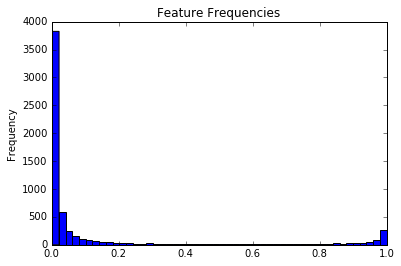

In [19]:
import matplotlib as plt
% matplotlib inline

feature_counts.plot.hist(title='Feature Frequencies', bins=50)

In [20]:
# define function to drop features that are shared by less than X% of sequences and/or more
# than 1-X% of sequences

def trim_feature_extremes(dataframe, percent_to_trim):
    total_rows = dataframe.shape[0]
    upper_threshold = (1 - percent_to_trim) * total_rows
    lower_threshold = percent_to_trim * total_rows
    column_filter_list = list((dataframe.sum(axis=0) >= lower_threshold) &
                                (dataframe.sum(axis=0) < upper_threshold)) 
                                #True = keep, False = drop
    column_filter_dict = zip(list(dataframe.columns), column_filter_list)
    columns_to_keep = [column for column, keepornot in column_filter_dict 
                        if keepornot == True]
    output_df = dataframe[columns_to_keep]
    return output_df
 

In [21]:
trimmed_features_df = trim_feature_extremes(features_df, 0.05)

trimmed_features_df.shape

(490, 1333)

# Build Decision Tree Classifier

    Use for feature selection


In [22]:
# define X & y as whole feature set without trimming features

X = features_df
y = neutdf.is_neutralized


In [23]:
# calculate best depth using roc_auc score

from sklearn.tree import DecisionTreeClassifier

max_depth_range = range(1, 101)

roc_auc_scores = []

from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treeclass = DecisionTreeClassifier(max_depth=depth)
    score = cross_val_score(treeclass, X, y, scoring='roc_auc', cv=10)
    roc_auc_scores.append(np.mean(score))
    
print roc_auc_scores

[0.77917852062588899, 0.85249525841631102, 0.88206334324755375, 0.8525327061511272, 0.84449868528815897, 0.86377106771843604, 0.8130840768998665, 0.83418358549937499, 0.81356712573817835, 0.8070576856761067, 0.78745851114272158, 0.80571145307987402, 0.80796855467908091, 0.79134876503297558, 0.79374865295917929, 0.79198887883098412, 0.81210558644769171, 0.83737607224449329, 0.808341954394586, 0.81702390189232299, 0.79153304021725079, 0.811505883874305, 0.8138357256778308, 0.82914511401353508, 0.82152840639682745, 0.815933337643864, 0.82798881417302472, 0.81244288546920118, 0.80451851372904015, 0.80700622871675498, 0.81585628690891843, 0.81292889779731881, 0.82148691753954917, 0.82258340876761937, 0.8110090952196215, 0.80486173973016073, 0.81860640544851082, 0.78623432044484687, 0.81601038837880946, 0.82626891245312295, 0.81423876029139186, 0.81458198629251266, 0.8187486529591792, 0.81030270701323348, 0.81218102073365228, 0.8077481788008104, 0.79934372171214274, 0.8181150049571102, 0.799

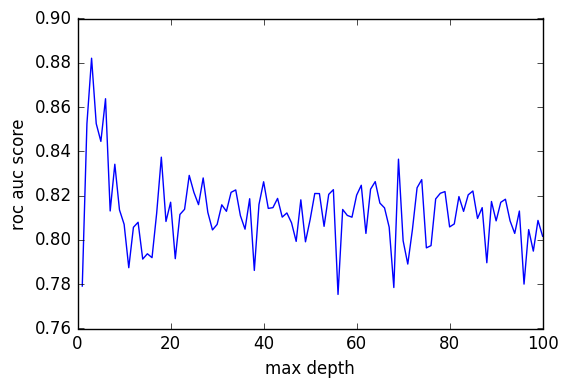

In [24]:
# graph roc_auc_scores vs max depth

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(max_depth_range, roc_auc_scores)
plt.xlabel('max depth')
plt.ylabel('roc auc score')

plt.rcdefaults()

In [25]:
sorted(zip(roc_auc_scores, max_depth_range), reverse=True)[0]

(0.88206334324755375, 3)

In [26]:
# fit tree using max depth of 10

treeclass = DecisionTreeClassifier(max_depth=10)
treeclass.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [37]:
# get feature importances

feat_import = pd.DataFrame({'feature': features_df.columns, 'importance': treeclass.feature_importances_})
feat_import.sort_values('importance', ascending=False).head(10)

,feature,importance
2083,363=PNGS,0.236450
2435,408=N,0.183398
3047,479=PNGS,0.127432
5078,7=L,0.053283
3070,480=S,0.038936
5468,872=V,0.032765
2671,429=Y,0.031546
2422,406=H,0.031275
404,160=A,0.025463
2685,430=W,0.021455


In [48]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[466]

576

In [39]:
# look at other feature importances at same sites

features_363 = [feat for feat in feat_import.feature if '363' in feat]
features_408 = [feat for feat in feat_import.feature if '408' in feat]

In [40]:
feat_import.set_index('feature', inplace=True)
import_feat = feat_import.transpose()
import_feat[features_363]

feature,363=D,363=E,363=H,363=I,363=K,363=L,363=M,363=N,363=PNGS,363=R,363=S,363=T,363=V,363=Y
importance,0,0,0,0,0,0,0,0,0.23645,0,0,0,0,0


In [41]:
import_feat[features_408]

feature,408=D,408=E,408=H,408=I,408=K,408=L,408=N,408=PNGS,408=R,408=S,408=T,408=V
importance,0,0,0,0,0,0,0.183398,0,0,0,0,0


# Build Random Forest
    
    Use randomized grid search CV for n_estimators, max_features

In [42]:
# import random forest classifier & define X & y using trimmed dataframe

from sklearn.ensemble import RandomForestClassifier

rfclass = RandomForestClassifier()

X = trimmed_features_df
y = neutdf.is_neutralized

In [45]:
from sklearn.grid_search import RandomizedSearchCV

estimators_range = range(1, 1502, 10)
feature_range = range(1, 502)

In [47]:
param_dist = dict(n_estimators=estimators_range, max_features=feature_range)
rand = RandomizedSearchCV(rfclass, param_dist, n_iter=50, scoring='roc_auc', cv=5)
rand.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,...41, 1351, 1361, 1371, 1381, 1391, 1401, 1411, 1421, 1431, 1441, 1451, 1461, 1471, 1481, 1491, 1501]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='roc_auc', verbose=0)

In [49]:
grid = pd.DataFrame(rand.grid_scores_).sort_values('mean_validation_score', ascending=False)
grid.head(50)

,parameters,mean_validation_score,cv_validation_scores
48,"{u'n_estimators': 291, u'max_features': 411}",0.912278,"[0.922222222222, 0.89161036036, 0.882601351351..."
40,"{u'n_estimators': 881, u'max_features': 411}",0.911934,"[0.913611111111, 0.902308558559, 0.88541666666..."
14,"{u'n_estimators': 991, u'max_features': 427}",0.911659,"[0.908055555556, 0.898367117117, 0.88569819819..."
15,"{u'n_estimators': 701, u'max_features': 501}",0.911601,"[0.904722222222, 0.902027027027, 0.88400900900..."
17,"{u'n_estimators': 331, u'max_features': 488}",0.911422,"[0.909444444444, 0.891328828829, 0.89020270270..."
20,"{u'n_estimators': 1111, u'max_features': 461}",0.910308,"[0.905833333333, 0.901463963964, 0.88654279279..."
41,"{u'n_estimators': 941, u'max_features': 491}",0.910283,"[0.911944444444, 0.89527027027, 0.880349099099..."
47,"{u'n_estimators': 821, u'max_features': 488}",0.910146,"[0.900277777778, 0.890484234234, 0.89245495495..."
26,"{u'n_estimators': 1201, u'max_features': 440}",0.909304,"[0.905833333333, 0.900337837838, 0.88119369369..."
25,"{u'n_estimators': 1341, u'max_features': 435}",0.908930,"[0.9025, 0.893018018018, 0.88597972973, 0.9752..."


In [50]:
# look at best parameters

print rand.best_score_
print rand.best_params_

0.912278292045
{'n_estimators': 291, 'max_features': 411}


In [51]:
# fit random forest with best parameters

rfclass = RandomForestClassifier(n_estimators=800, max_features=450, oob_score=True)
rfclass.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=450, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [52]:
# look at feature importances

forest_features_import = pd.DataFrame({'feature': X.columns, 'importance': rfclass.feature_importances_})
forest_features_import.sort_values('importance', ascending=False).head(10)

,feature,importance
424,363=PNGS,0.148488
488,408=N,0.052014
494,411=S,0.030612
627,479=PNGS,0.028908
634,482=W,0.024628
612,466=G,0.016456
632,481=T,0.014737
493,411=PNGS,0.013893
485,406=H,0.010319
1233,930=W,0.009623


In [56]:
# look up position in HXB2 for it's corresponding coordinate in the MSA

reference = sequence_tokenizer(HXB2.seq)
decoder = dict(enumerate(reference, start=1))
decoder[392]

479

In [57]:
# oob score

rfclass.oob_score_

0.88571428571428568

# Fit Logistic Regression with best features

    Evaluate with different iterations of selected features
    

In [58]:
# define new df with selected features & perform train/test split

selected_features = ['363=PNGS', '408=N', '411=S', '479=PNGS', '482=W']
X = features_df[selected_features]
y = neutdf.is_neutralized

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)

In [59]:
# fit logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [60]:
# look at coefficients

print logreg.coef_

[[  3.1111298    2.59049643   0.99078487  11.07237876   1.29615324]]


In [61]:
# evaluate log loss

from sklearn import metrics

y_pred_proba = logreg.predict_proba(X_test)
print metrics.log_loss(y_test, y_pred_proba)

0.331746535146


In [62]:
# evaluate MCC

y_pred_class = logreg.predict(X_test)
print metrics.matthews_corrcoef(y_test, y_pred_class)

0.753706356528


In [63]:
# do above with different feature combinations

feature_selections = [['363=PNGS', '408=N', '411=S', '479=PNGS', '482=W'], ['363=PNGS', '408=N', '411=S', '479=PNGS'], 
                      ['363=PNGS', '408=N', '411=S'], ['363=PNGS', '408=N'], ['363=PNGS']]

log_loss_scores = []
MCC_scores = []

for selection in feature_selections:
    X = features_df[selection]
    y = neutdf.is_neutralized
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.3)
    logreg = LogisticRegression(C=1e9)
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, y_pred_proba)
    y_pred_class = logreg.predict(X_test)
    MCC = metrics.matthews_corrcoef(y_test, y_pred_class)
    log_loss_scores.append(log_loss)
    MCC_scores.append(MCC)

In [64]:
# make a dataframe of the above

log_reg_eval = pd.DataFrame({'features': feature_selections, 'log loss': log_loss_scores, 'MCC': MCC_scores})
log_reg_eval.sort_values('MCC', ascending=False)

,MCC,features,log loss
1,0.664071,"[363=PNGS, 408=N, 411=S, 479=PNGS]",0.334308
0,0.651456,"[363=PNGS, 408=N, 411=S, 479=PNGS, 482=W]",0.361570
2,0.626258,"[363=PNGS, 408=N, 411=S]",0.385761
3,0.548702,"[363=PNGS, 408=N]",0.416775
4,0.000000,[363=PNGS],0.430039
